Using device: cuda

Model Statistics:
Total Parameters: 69,938,172
Trainable Parameters: 69,938,172
Training Set Tokens: 1,082,638,872
Validation Set Tokens: 120,293,208
Total Tokens: 1,202,932,080



/tmp/ipykernel_20/3929256682.py:280: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=="cuda") else None
/tmp/ipykernel_20/3929256682.py:251: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Starting training...
Step 0 | Train: 10.9254 | Val: 10.9250 | PPL: 55547.14
New best checkpoint saved: latent_gpt/best_model.pt


/tmp/ipykernel_20/3929256682.py:323: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Step 200 | Train: 6.8592 | Val: 6.8773 | PPL: 970.04
New best checkpoint saved: latent_gpt/best_model.pt
Step 400 | Train: 6.0869 | Val: 6.0917 | PPL: 442.19
New best checkpoint saved: latent_gpt/best_model.pt
Step 600 | Train: 5.7099 | Val: 5.7528 | PPL: 315.09
New best checkpoint saved: latent_gpt/best_model.pt
Step 800 | Train: 5.4744 | Val: 5.5415 | PPL: 255.05
New best checkpoint saved: latent_gpt/best_model.pt
Step 1000 | Train: 5.3009 | Val: 5.3554 | PPL: 211.74
New best checkpoint saved: latent_gpt/best_model.pt
Step 1200 | Train: 5.1196 | Val: 5.1500 | PPL: 172.43
New best checkpoint saved: latent_gpt/best_model.pt
Step 1400 | Train: 5.0162 | Val: 5.0448 | PPL: 155.22
New best checkpoint saved: latent_gpt/best_model.pt
Step 1600 | Train: 4.8769 | Val: 4.9650 | PPL: 143.31
New best checkpoint saved: latent_gpt/best_model.pt
Step 1800 | Train: 4.8173 | Val: 4.8770 | PPL: 131.23
New best checkpoint saved: latent_gpt/best_model.pt
Step 2000 | Train: 4.7239 | Val: 4.8205 | PPL: 124

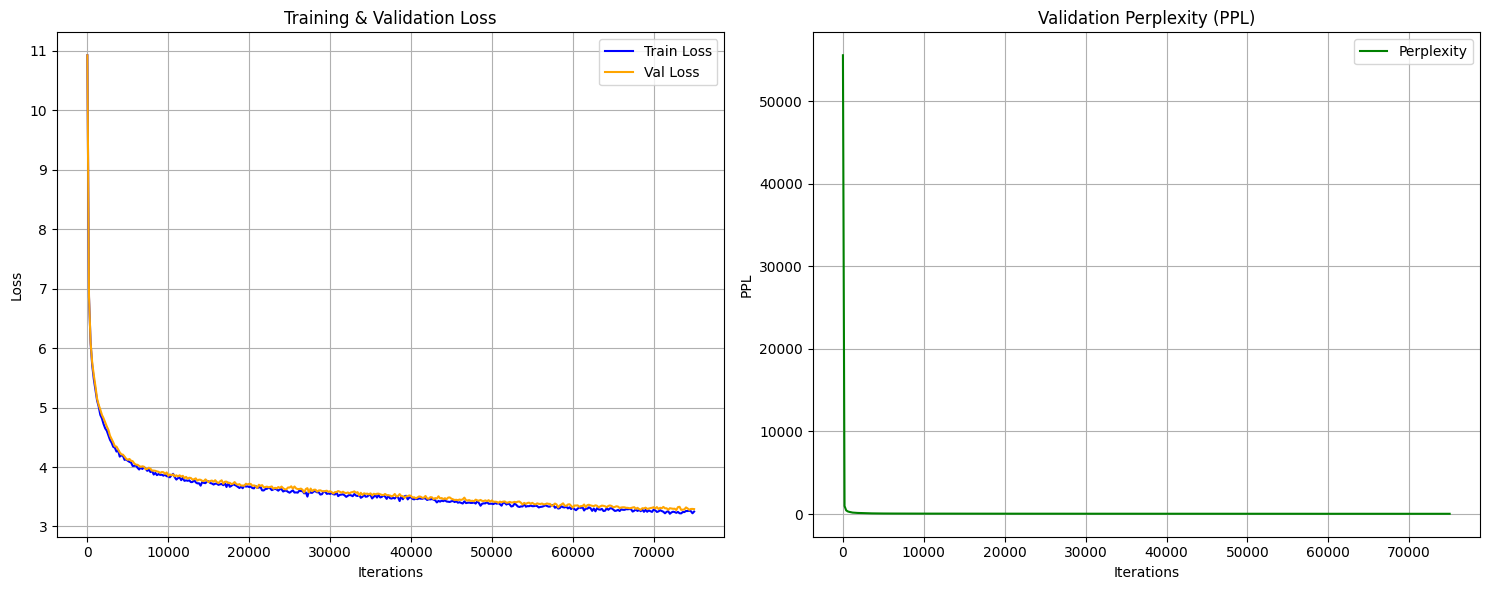


=== MODEL GENERATION DEMO ===
PROMPT: The history of science is
----------------------------------------
RESPONSE:
The history of science is a work of modern science that was first published in the uk in 1972 by the american mathematical society in the 1950s. it was first published in 1973 by the israeli institute for scientific and technological sciences. in 1975, "science" was expanded to include "the evolution of the universe", "the new science". the original core text was written from the seventeenth century, and remained in print in the 1960s. it has since been adapted from the latter two.

from
----------------------------------------


In [1]:
"""
SCRIPT: Train LatentGPT using memmap + MLA-3 attention (CORRECTED)
------------------------------------------------------
- FIX: Removed Absolute Positional Embeddings (conflicted with RoPE)
- FIX: Applied Weight Decay only to 2D parameters (Matrices)
- ADDED: Loss/PPL Plotting
- ADDED: Inference/Generation script
"""

import os
import json
import math
import time
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import nullcontext

# Try importing tiktoken for decoding; if not found, generation will use raw IDs
try:
    import tiktoken
    HAS_TIKTOKEN = True
except ImportError:
    HAS_TIKTOKEN = False
    print("WARNING: tiktoken not found. Generation will show token IDs only.")

# ================= CONFIG =================
MEMMAP_BIN_PATH = "/kaggle/input/jklu-en-memap-5gb/wikipedia_tokens.bin"
MEMMAP_META_PATH = "/kaggle/input/jklu-en-memap-5gb/wikipedia_tokens_meta.json"

# Model hyperparameters
n_embd = 512
n_head = 8
n_layer = 6
dropout = 0.1

# Training hyperparameters
batch_size = 8
block_size = 512
learning_rate = 6e-4
weight_decay = 0.1
grad_clip = 1.0
max_iters = 75000 # Reduced for demo purposes; set back to 75000 for full run
eval_interval = 200
eval_iters = 100
warmup_iters = 1000
gradient_accumulation_steps = 2
use_amp = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================= LOAD MEMMAP =================
with open(MEMMAP_META_PATH, "r") as f:
    meta = json.load(f)

tokens_mem = np.memmap(
    MEMMAP_BIN_PATH,
    dtype=np.int32,
    mode="r",
)

n_tokens = tokens_mem.shape[0]
split_idx = int(0.9 * n_tokens)
train_data = tokens_mem[:split_idx]
val_data = tokens_mem[split_idx:]
vocab_size = meta.get("vocab_size", 50257)

# ================= BATCHING =================
def get_batch(split):
    data = train_data if split == "train" else val_data
    data_len = len(data)
    ix = torch.randint(0, data_len - block_size - 1, (batch_size,))
    x = torch.empty((batch_size, block_size), dtype=torch.long)
    y = torch.empty((batch_size, block_size), dtype=torch.long)
    for i in range(batch_size):
        start = int(ix[i])
        chunk = data[start : start + block_size + 1].astype(np.int64)
        x[i] = torch.from_numpy(chunk[:-1])
        y[i] = torch.from_numpy(chunk[1:])
    return x.to(device), y.to(device)

# ================= MODEL COMPONENTS =================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        rms = torch.norm(x, dim=-1, keepdim=True) / math.sqrt(x.shape[-1])
        return self.weight * (x / (rms + self.eps))

def apply_rope_x(x, cos, sin):
    B,H,S,D = x.shape
    assert D % 2 == 0
    x_ = x.view(B,H,S,D//2,2)
    x_even = x_[...,0]
    x_odd  = x_[...,1]
    cos = cos[..., :x_even.shape[-1]]
    sin = sin[..., :x_even.shape[-1]]
    rotated_even = x_even * cos - x_odd * sin
    rotated_odd  = x_even * sin + x_odd * cos
    return torch.stack([rotated_even, rotated_odd], dim=-1).reshape(B,H,S,D)

class MLA(nn.Module):
    def __init__(self, d_model, n_heads, max_len=1024, rope_theta=10000.0):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dh = d_model // n_heads
        self.q_proj_dim = d_model // 2
        self.kv_proj_dim = (2*d_model)//3
        self.qk_nope_dim = self.dh//2
        self.qk_rope_dim = self.dh//2

        self.W_dq = nn.Parameter(0.01*torch.randn(d_model, self.q_proj_dim))
        self.W_uq = nn.Parameter(0.01*torch.randn(self.q_proj_dim, d_model))
        self.q_layernorm = nn.LayerNorm(self.q_proj_dim)

        self.W_dkv = nn.Parameter(0.01*torch.randn(d_model, self.kv_proj_dim + self.qk_rope_dim))
        self.W_ukv = nn.Parameter(0.01*torch.randn(self.kv_proj_dim, d_model + self.n_heads*self.qk_nope_dim))
        self.kv_layernorm = nn.LayerNorm(self.kv_proj_dim)

        self.W_o = nn.Parameter(0.01*torch.randn(d_model,d_model))

        self.max_seq_len = max_len
        freqs = 1.0 / (rope_theta ** (torch.arange(0,self.dh,2).float()/self.dh))
        emb = torch.outer(torch.arange(self.max_seq_len).float(), freqs)
        self.register_buffer("cos_cached", emb.cos()[None,None,:,:])
        self.register_buffer("sin_cached", emb.sin()[None,None,:,:])

    def forward(self, x, kv_cache=None, past_length=0):
        B,S,D = x.shape
        # Q Logic
        compressed_q = self.q_layernorm(x @ self.W_dq)
        Q = (compressed_q @ self.W_uq).view(B, S, self.n_heads, self.dh).transpose(1,2)
        Q, Q_rope = torch.split(Q,[self.qk_nope_dim,self.qk_rope_dim],dim=-1)
        
        # RoPE Q
        cos_q = self.cos_cached[:, :, past_length:past_length+S, :].to(x.device)
        sin_q = self.sin_cached[:, :, past_length:past_length+S, :].to(x.device)
        Q_rope = apply_rope_x(Q_rope, cos_q, sin_q)

        # KV Logic
        KV_for_lora, K_for_rope = torch.split(x @ self.W_dkv,[self.kv_proj_dim,self.qk_rope_dim],dim=-1)
        KV = (self.kv_layernorm(KV_for_lora) @ self.W_ukv).view(B,S,self.n_heads,self.dh+self.qk_nope_dim).transpose(1,2)
        K,V = torch.split(KV,[self.qk_nope_dim,self.dh],dim=-1)

        # RoPE K
        K_for_rope = K_for_rope.view(B,1,S,self.qk_rope_dim).repeat(1,self.n_heads,1,1)
        cos_k = self.cos_cached[:,:,:S,:].to(x.device)
        sin_k = self.sin_cached[:,:,:S,:].to(x.device)
        K_rope = apply_rope_x(K_for_rope, cos_k, sin_k)

        # Attention
        q_heads = torch.cat([Q, Q_rope], dim=-1)
        k_heads = torch.cat([K, K_rope], dim=-1)
        
        mask = torch.ones((S,S),device=x.device).tril(diagonal=past_length)[None,None,:,:]
        x = F.scaled_dot_product_attention(q_heads, k_heads, V, attn_mask=mask==1)
        return (x.transpose(1,2).reshape(B,S,D) @ self.W_o.T), None

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd,n_embd),
            nn.Dropout(dropout)
        )
    def forward(self,x): return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self,n_embd,n_head,dropout,block_size):
        super().__init__()
        self.ln1 = RMSNorm(n_embd)
        self.ln2 = RMSNorm(n_embd)
        self.attn = MLA(n_embd,n_head,block_size)
        self.ff = FeedForward(n_embd,dropout)
    def forward(self,x):
        out, _ = self.attn(self.ln1(x))
        x = x + out
        x = x + self.ff(self.ln2(x))
        return x

class LatentGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.tok_emb = nn.Embedding(self.vocab_size, n_embd)
        # FIX: Removed self.pos_emb (Absolute Pos Embeddings conflict with RoPE)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([TransformerBlock(n_embd,n_head,dropout,block_size) for _ in range(n_layer)])
        self.ln_f = RMSNorm(n_embd)
        self.lm_head = nn.Linear(n_embd,self.vocab_size,bias=False)
        self.apply(self._init_weights)

    def _init_weights(self,module):
        if isinstance(module,nn.Linear) or isinstance(module,nn.Embedding):
            nn.init.normal_(module.weight,0.0,0.02)
            if hasattr(module,'bias') and module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        # FIX: Removed pos_emb addition here
        x = self.drop(self.tok_emb(idx)) 
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1,self.vocab_size), targets.view(-1), ignore_index=-1)
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ================= HELPER FUNCTIONS =================
def get_lr(iter_):
    if iter_<warmup_iters: return learning_rate*iter_/warmup_iters
    decay_ratio = (iter_-warmup_iters)/(max_iters-warmup_iters)
    coeff = 0.5*(1+math.cos(math.pi*decay_ratio))
    return learning_rate*0.1 + coeff*(learning_rate-learning_rate*0.1)

@torch.no_grad()
def estimate_loss(model, eval_iters):
    model.eval()
    losses = {"train":[],"val":[]}
    ctx = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else nullcontext
    for split in ["train","val"]:
        for _ in range(eval_iters):
            xb,yb = get_batch(split)
            with ctx():
                _, loss = model(xb,yb)
            losses[split].append(loss.item())
    model.train()
    return {k:sum(v)/len(v) for k,v in losses.items()}

# ================= INITIALIZATION =================
model = LatentGPT().to(device)

# Print model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Training Set Tokens: {len(train_data):,}")
print(f"Validation Set Tokens: {len(val_data):,}")
print(f"Total Tokens: {n_tokens:,}\n")

# FIX: Weight Decay Logic (Don't decay LayerNorm or Bias)
param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad}
decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
optim_groups = [
    {'params': decay_params, 'weight_decay': weight_decay},
    {'params': nodecay_params, 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate)

scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=="cuda") else None
ctx = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else nullcontext

# ================= TRAINING LOOP WITH BEST CHECKPOINT ONLY =================
metrics = {"train_loss":[],"val_loss":[],"ppl":[],"steps":[]}
best_val_loss = float('inf')
start_time = time.time()

print("Starting training...")
for step in range(max_iters):
    # Update LR
    lr = get_lr(step)
    for pg in optimizer.param_groups: pg["lr"] = lr

    # Evaluation
    if step % eval_interval == 0 or step == max_iters - 1:
        losses = estimate_loss(model, eval_iters)
        ppl = math.exp(losses["val"])
        metrics["train_loss"].append(losses["train"])
        metrics["val_loss"].append(losses["val"])
        metrics["ppl"].append(ppl)
        metrics["steps"].append(step)
        
        print(f"Step {step} | Train: {losses['train']:.4f} | Val: {losses['val']:.4f} | PPL: {ppl:.2f}")

        # Save best checkpoint only
        if losses["val"] < best_val_loss:
            best_val_loss = losses["val"]
            checkpoint_path = "latent_gpt/best_model.pt"
            os.makedirs("latent_gpt", exist_ok=True)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': losses['val'],
                'metrics': metrics
            }, checkpoint_path)
            print(f"New best checkpoint saved: {checkpoint_path}")

    # Training step
    optimizer.zero_grad(set_to_none=True)
    for micro in range(gradient_accumulation_steps):
        xb, yb = get_batch("train")
        with ctx():
            _, loss = model(xb, yb)
            loss = loss / gradient_accumulation_steps
        if scaler: scaler.scale(loss).backward()
        else: loss.backward()

    if scaler:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
    else:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

# ================= PLOTTING =================
print("Training complete. Generating plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss Plot
ax1.plot(metrics["steps"], metrics["train_loss"], label="Train Loss", color="blue")
ax1.plot(metrics["steps"], metrics["val_loss"], label="Val Loss", color="orange")
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Perplexity Plot
ax2.plot(metrics["steps"], metrics["ppl"], label="Perplexity", color="green")
ax2.set_title("Validation Perplexity (PPL)")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("PPL")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()

# ================= INFERENCE / DEMO =================
print("\n=== MODEL GENERATION DEMO ===")

# 1. Setup Tokenizer (Tiktoken for GPT-2 is standard for these bins)
if HAS_TIKTOKEN:
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)
else:
    # Fallback if no tokenizer installed
    encode = lambda s: [0] # Dummy
    decode = lambda l: f"Tokens: {l}"

# 2. Define Prompt
prompt_text = "The history of science is"
print(f"PROMPT: {prompt_text}")

# 3. Encode
start_ids = encode(prompt_text)
x = torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...]

# 4. Generate
model.eval()
with torch.no_grad():
    # Generate 100 new tokens
    y = model.generate(x, max_new_tokens=100, temperature=0.8, top_k=200)

# 5. Decode & Print
output_text = decode(y[0].tolist())
print("-" * 40)
print(f"RESPONSE:\n{output_text}")
print("-" * 40)